In [1]:
import disentangler as dt
from disentangler.dependencies import *
import scvi

atac_data = dt.bonemarrow.utils.load_ATAC_data()

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [2]:
mira_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_ATAC)
mira_no_correction = mira.topics.load_model(dt.bonemarrow.config.MIRA_ATAC_NO_CORRECTION)

peakvi = scvi.model.PEAKVI.load(dt.bonemarrow.config.PEAKVI, adata = atac_data)

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


INFO     File data/bonemarrow/models/peakvi.pth/model.pt already downloaded                  


INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [3]:
mira_no_correction.predict(atac_data, add_key='X_no_correction_topics', add_cols=False)

mira_no_correction.get_umap_features(atac_data, box_cox=0.1, 
                                     key = 'X_no_correction_topics',
                                    add_key = 'MIRA_no_correction_umap_features')

mira_no_correction.get_umap_features(atac_data, box_cox=0.5, 
                                     key = 'X_no_correction_topics',
                                    add_key = 'X_no_correction_umap_features')

Predicting latent vars:   0%|          | 0/263 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_no_correction_topics
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_no_correction_topics from obsm
INFO:mira.adata_interface.core:Added key to obsm: MIRA_no_correction_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_no_correction_topics from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_no_correction_umap_features


In [4]:
mira_model.predict(atac_data)
mira_model.get_umap_features(atac_data, box_cox=0.1)

Predicting latent vars:   0%|          | 0/263 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


In [5]:
atac_data.obsm['MIRA_umap_features'] = atac_data.obsm['X_umap_features'].copy()
mira_model.get_umap_features(atac_data, box_cox = 0.5)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


In [6]:
atac_data.obsm['peakvi_features'] = peakvi.get_latent_representation(atac_data)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

svd_pipeline = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=30)),
    ('scaler', StandardScaler()),
])

atac_data.obsm['X_LSI'] = svd_pipeline.fit_transform(atac_data.X)

In [8]:
import harmonypy as hm
ho = hm.run_harmony(atac_data.obsm['X_LSI'][:,:30], atac_data.obs, ['Site','DonorNumber'])

atac_data.obsm['X_harmony'] = ho.Z_corr.T

2022-08-25 12:22:18,099 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2022-08-25 12:22:45,089 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2022-08-25 12:23:11,644 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2022-08-25 12:23:37,893 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2022-08-25 12:24:04,452 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2022-08-25 12:24:24,690 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2022-08-25 12:24:38,134 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2022-08-25 12:25:05,238 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


In [9]:
joint_celltype_batchcols = atac_data.obs['cell_type'].astype(str) \
    + ":" + atac_data.obs['Site'].astype(str)

In [10]:
latent_spaces = ['X_umap_features', 'X_no_correction_umap_features','peakvi_features','X_harmony','X_LSI']
umap_spaces = ['MIRA_umap_features', 'MIRA_no_correction_umap_features'] + latent_spaces[2:]

In [11]:
from sklearn.metrics import silhouette_samples

In [13]:
for space in latent_spaces:
    
    batch = \
        silhouette_samples(
            atac_data.obsm[space],
            joint_celltype_batchcols,
        )
    
    
    cell = \
        silhouette_samples(
            atac_data.obsm[space],
            atac_data.obs_vector('cell_type'),
        )
    
    atac_data.obs[space + '_batch-silhouette'] = batch
    atac_data.obs[space + '_silhouette'] = cell
    
    print(space + ':', np.mean(cell), np.mean(batch))

X_umap_features: 0.16596693700597734 -0.05866639904496883
X_no_correction_umap_features: 0.1370102798551767 0.007664476163310613
peakvi_features: 0.12612902 -0.039336577
X_harmony: 0.09364619 -0.05466526
X_LSI: 0.079830706 -0.018529613


In [14]:
for space in umap_spaces:
    sc.pp.neighbors(atac_data, use_rep = space, metric = 'manhattan' if space == 'MIRA_umap_features' else 'euclidean')
    sc.tl.umap(atac_data, min_dist = 0.1, negative_sample_rate = 3)
    atac_data.obsm[space + '_UMAP'] = atac_data.obsm['X_umap'].copy()

In [15]:
!mkdir -p sup1/
!mkdir -p sup1/umaps

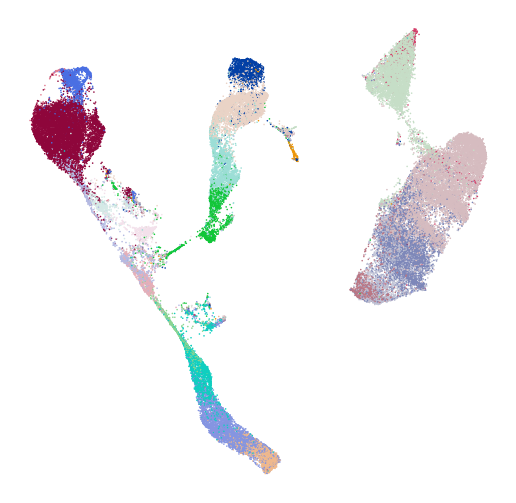

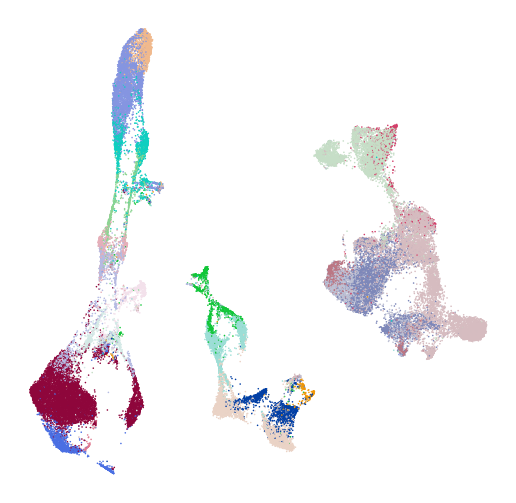

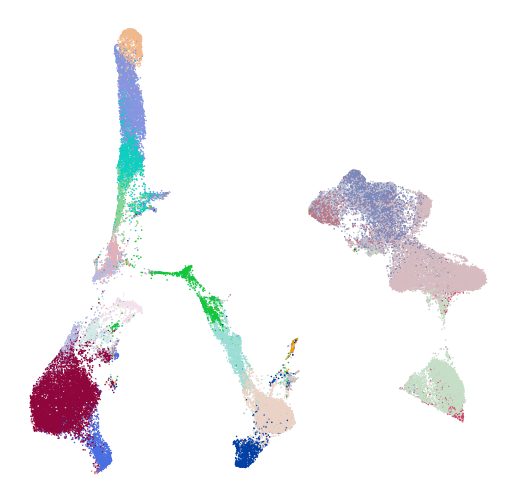

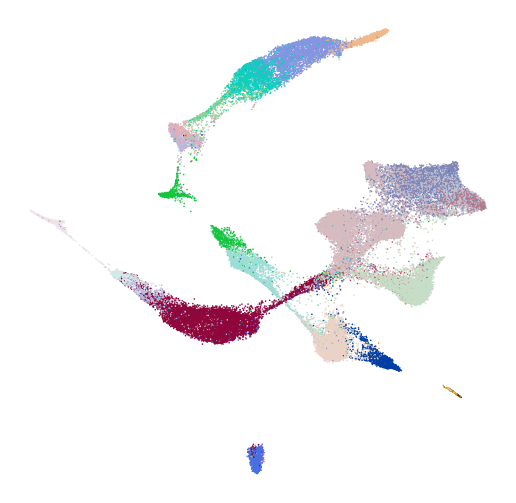

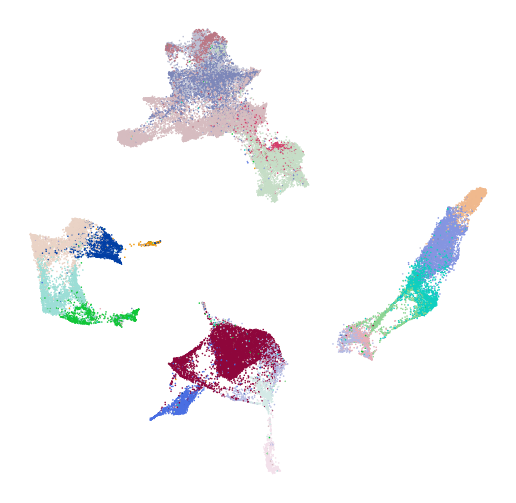

In [17]:
for basis in umap_spaces:
    
    fig, ax = plt.subplots(1,1,figsize=(9,9))
    sc.pl.embedding(atac_data, color = 'cell_type', ax = ax, frameon=False, s = 10, palette= dt.bonemarrow.colors.CELL_PALETTE,
              legend_loc='none', title = '', show = False, alpha = 1., basis = basis + '_UMAP')
    plt.savefig('sup1/umaps/{}_celltypes.png'.format(basis), dpi = 300, bbox_inches = 'tight')

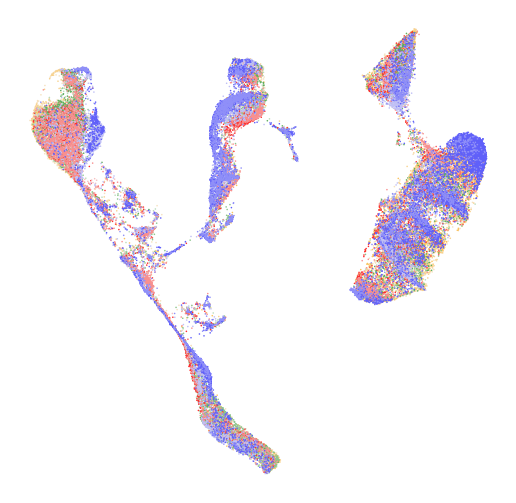

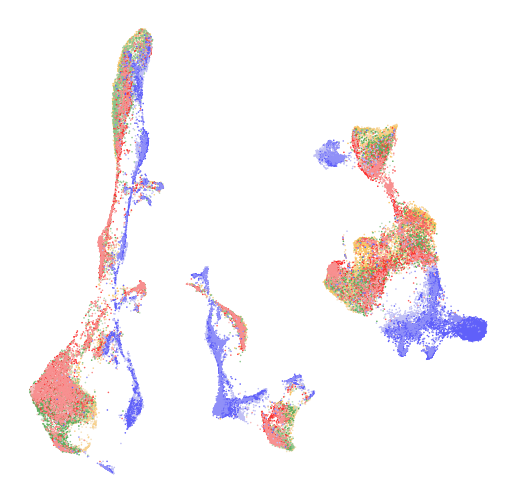

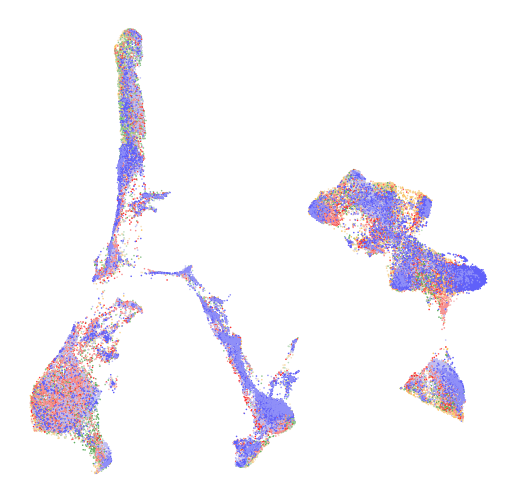

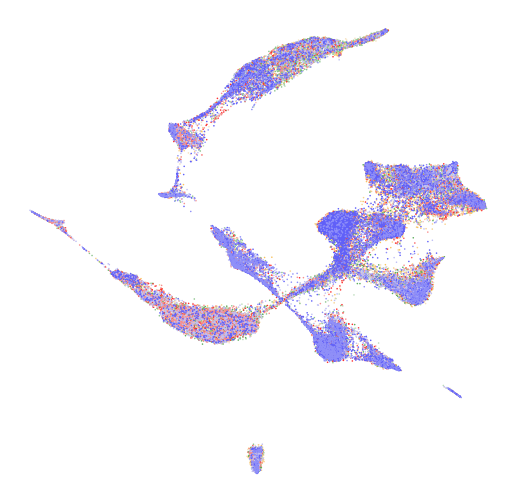

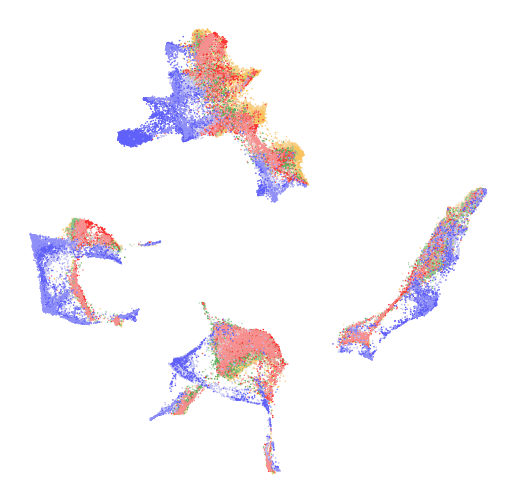

In [18]:
for basis in umap_spaces:
    
    fig, ax = plt.subplots(1,1,figsize=(9,9))
    sc.pl.embedding(atac_data, color = 'batch', ax = ax, frameon=False, s = 10, palette= dt.bonemarrow.colors.BATCH_PALETTE,
              legend_loc='none', title = '', show = False, alpha = 1., basis = basis + '_UMAP')
    plt.savefig('sup1/umaps/{}_batch.png'.format(basis), dpi = 300, bbox_inches = 'tight')

In [20]:
silhouette_cols = ['X_umap_features_batch-silhouette', 'X_umap_features_silhouette',
        'X_no_correction_umap_features_batch-silhouette', 'X_no_correction_umap_features_silhouette',
       'peakvi_features_batch-silhouette', 'peakvi_features_silhouette',
       'X_harmony_batch-silhouette', 'X_harmony_silhouette',
       'X_LSI_batch-silhouette', 'X_LSI_silhouette']

silhouettes = atac_data.obs[silhouette_cols].mean(0).to_frame().reset_index()\
    .rename(columns = {'index' : 'space_type', 0 : 'score'})

silhouettes['space'] = list(map(lambda x : '_'.join(x[:-1]), silhouettes['space_type'].str.split('_')))
silhouettes['batch_features'] = silhouettes['space_type'].str.contains('batch')

scores = silhouettes.pivot('space', columns='batch_features', values='score').reset_index()

scores['is_supervised'] = scores.space == 'scanvi_features'

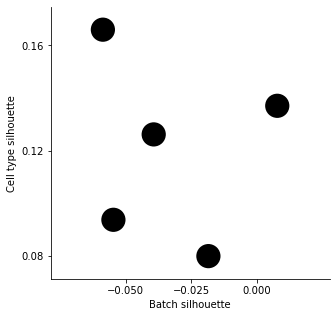

In [45]:
ax = fig, ax = plt.subplots(1,1,figsize=(5,5))

sns.scatterplot(
    data = scores,
    y = False,
    x = True,
    s = 450,
    palette= {True : 'white', False : 'black'},
    edgecolor = 'black',
    linewidth = 3,
    hue = 'is_supervised',
    ax  = ax,
    legend=False
)

ax.set_xmargin(0.3)
ax.set_ymargin(0.3)
ax.axis('equal')
ax.set(ylabel = 'Cell type silhouette', xlabel = 'Batch silhouette',
      xticks = [-0.05, -0.025, -0,], yticks = [0.08, 0.12, 0.16])
sns.despine()

plt.savefig('sup1/silhouette_scores.svg')

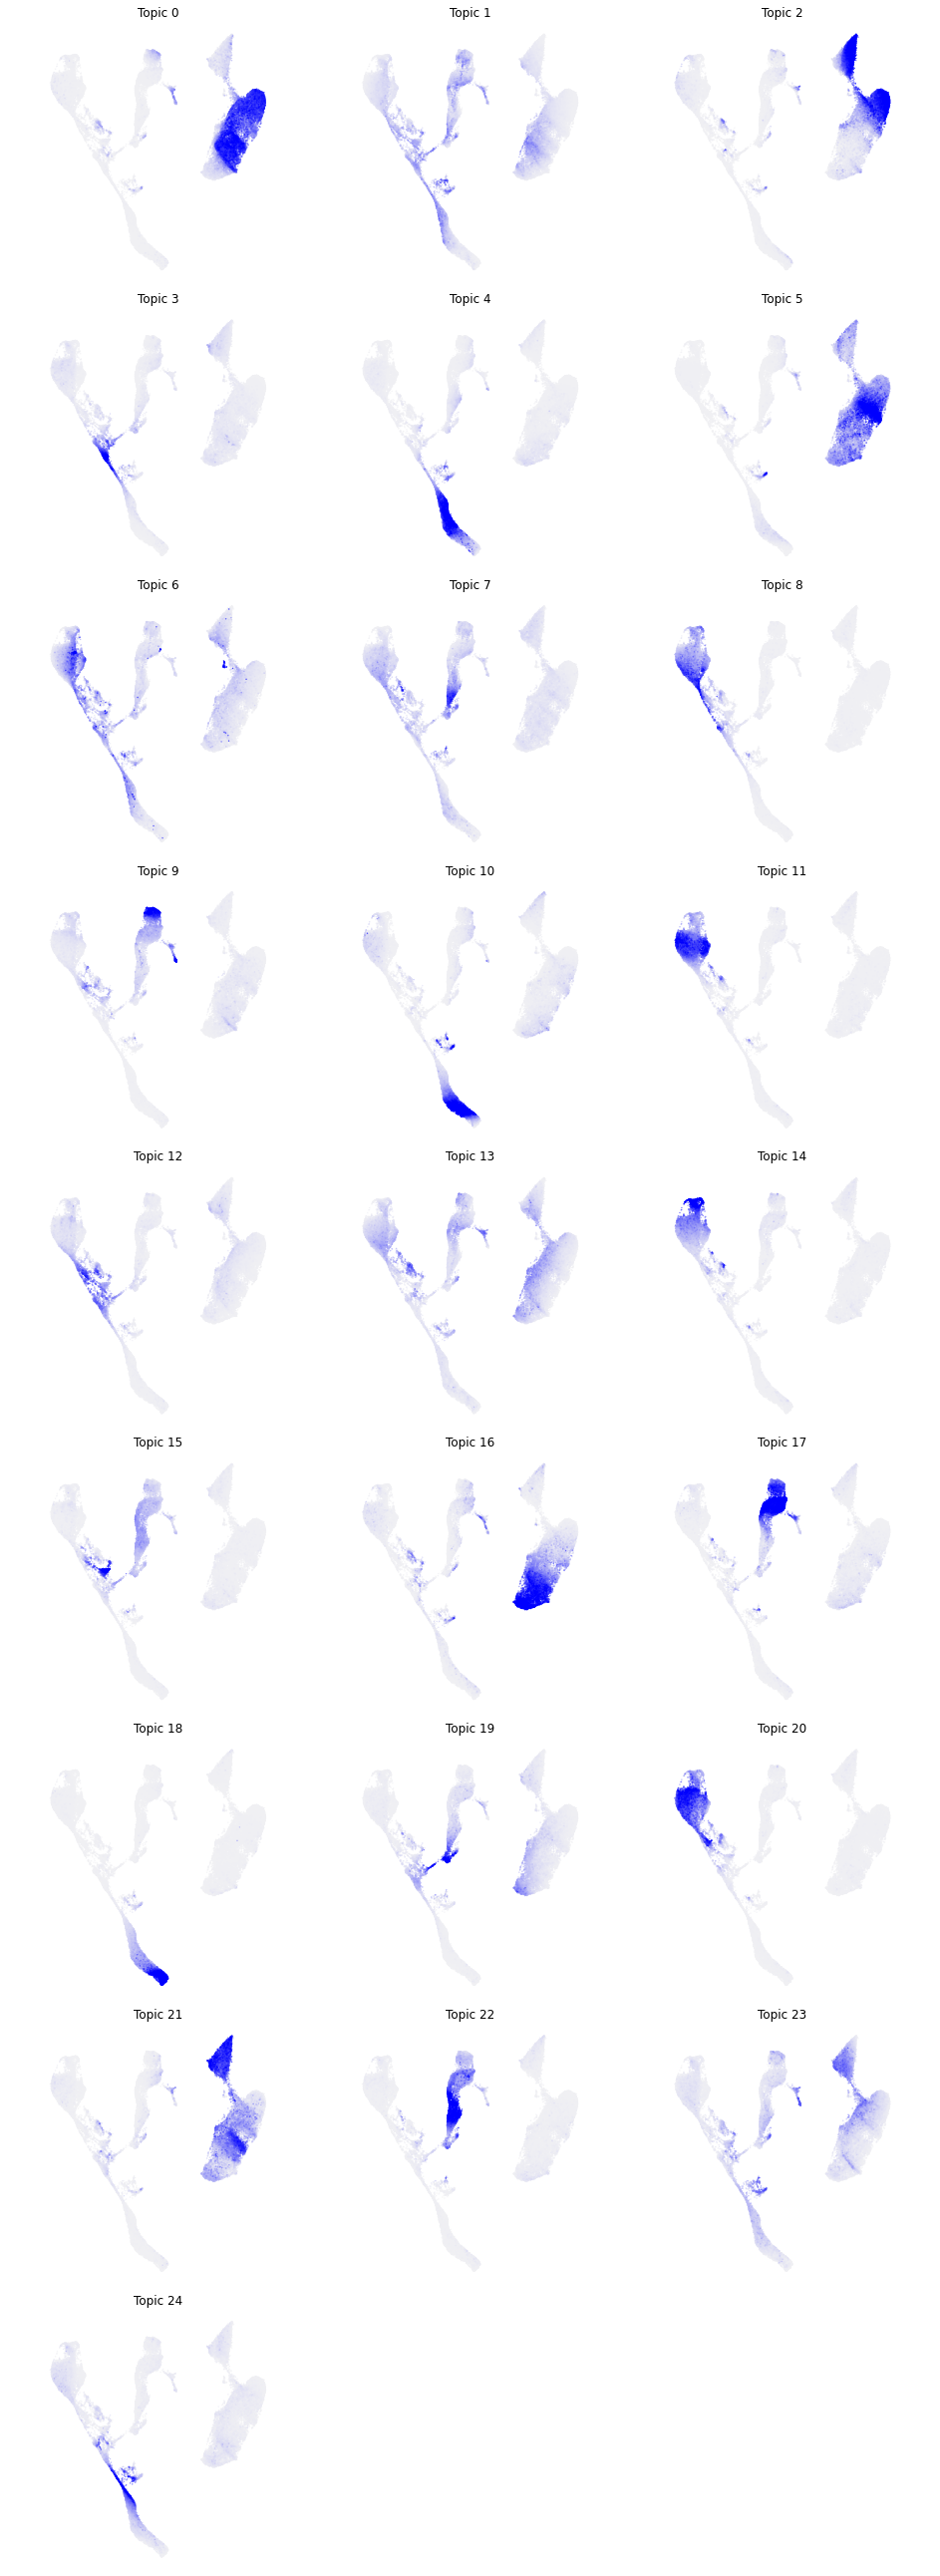

In [47]:
from mira.plots.base import map_plot, plot_umap, map_colors

def topic_umap(ax, topic):
    
    ax = plot_umap(
        atac_data.obsm['MIRA_umap_features_UMAP'],
        atac_data.obs_vector(topic),
        palette=sns.color_palette('light:blue', as_cmap=True),
        figsize=(5,5),
        size = 0.1,
        add_legend=False,
        vmin=-0.0,
        vmax = 0.5,
        ax = ax,
        title = 'Topic ' + topic.split('_')[-1]
    )
    ax.set_xmargin(0.2)
    ax.set_xmargin(0.2)

map_plot(topic_umap, [[x] for x in mira_model.topic_cols], plots_per_row=3, height=4, aspect=1.1)
plt.savefig('sup1/topics.png', bbox_inches = 'tight', dpi = 300)